In [6]:
import numpy as np
import torch
from torchvision import transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
import random
import nltk

from data_loader import *
import cv2
from utils import *
from models import *
# Watch for any changes in vocabulary.py, data_loader.py or model.py, and re-load it automatically.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

img_path = '../data/flickr30k-images'
ann_path = '../data/results_20130124.token'

dataset = Flickr30kData(img_root=img_path,
                       ann_file=ann_path,
                       transform=transform,
                       fetch_mode='default',
                       mode="test",
                       disp_mode="allretrieval",
                       num_test=1)

In [8]:
def load_model(model_path='model_13epochs_sumboth.tar',map_location='cpu'):
    image_model = VGG19(pretrained=True)
    caption_model = LSTMBranch()
    checkpoint = torch.load(model_path, map_location)
    start_epoch = checkpoint['epoch']
    best_loss = checkpoint['best_loss']
    image_model.load_state_dict(checkpoint['image_model'])
    caption_model.load_state_dict(checkpoint['caption_model'])
    print ("Loaded checkpoint '{}' (epoch {})".format(model_path,checkpoint['epoch']))
    return image_model, caption_model

def gen_matchmap(image_model, caption_model, image_tensor, caption_tensor):
    image_op = image_model(image_tensor)
    caption_op = caption_model(caption_tensor)

    n_imgs = image_op.size(0)
    matchmap_list = []

    for i in range(n_imgs):
        matchmap = matchmap_generate(image_op[i],caption_op[i])
        mm = matchmap.detach().numpy()
        matchmap_list.append(mm)

    return matchmap_list

def get_output_img(image_tensor,image_model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image_model = image_model.to(device)
    image_model.eval()
    image_ip_val = image_tensor.to(device)
    image_output_val = image_model(image_ip_val)
    print ("Sanity Check ---> Size of the output tensor from Image Model ",image_output_val.shape)
    return image_output_val

def get_output_cap(caption_glove_tensor,caption_model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    caption_model = caption_model.to(device)
    caption_model.eval()
    all_caption_output_val=[]
    caption_glove_ip_val = caption_glove_tensor.to(device)
    caption_output_val = caption_model(caption_glove_ip_val)
    #print ("Sanity Check ---> Size of the output tensor from LSTM ",caption_output_val.shape)
    return caption_output_val

def get_output(image_tensor,image_model,caption_glove_tensor,caption_model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image_model = image_model.to(device)
    caption_model = caption_model.to(device)
    image_model.eval()
    caption_model.eval()
    image_ip_val = image_tensor.to(device)
    all_caption_output_val=[]
    caption_glove_ip_val = caption_glove_tensor.to(device)
    with torch.no_grad():
        caption_output_val = caption_model(caption_glove_ip_val)
        image_output_val = image_model(image_ip_val)
    print ("Sanity Check ---> Size of the output tensor from LSTM ",caption_output_val.shape)
    print ("Sanity Check ---> Size of the output tensor from Image Model ",image_output_val.shape)
    return image_output_val, caption_output_val



def get_sim_mat(image_output,caption_glove_tensor_output,score_type):
    sim_mat=[]
    for captiontensor in caption_glove_tensor_output:
        captiontensor = torch.unsqueeze(captiontensor,dim=0)
        sim_val = compute_matchmap_similarity_matrix(image_output,captiontensor,score_type)
        sim_mat.append(sim_val)
    return sim_mat

In [9]:
def get_data(batch_size):
    data_loader = data.DataLoader(dataset=dataset,
                                  batch_size=1,
                                  shuffle=True)

    dataloader_iterator = iter(data_loader)

    for i in range(len(dataset)):
        img, caption_gloves, captions5k, groundtruth,img_cap_dict,img_cap_len_dict  = next(dataloader_iterator)
        break
    return img, caption_gloves, captions5k, groundtruth,img_cap_dict,img_cap_len_dict

In [11]:
image_model, caption_model = load_model()
batch_size = 64
score_type = 'Avg_Both'
image_tensor,caption_glove_list,captions,ground_truth_captions,img_cap_dict,img_cap_len_dict = get_data(1)
new_caption_glove = torch.squeeze(caption_glove_list,dim=0)
new_image_tensor= torch.squeeze(image_tensor,dim=0)

image_output, caption_glove_tensor_output = get_output(new_image_tensor,image_model,new_caption_glove,caption_model)

Loaded checkpoint 'model_13epochs_sumboth.tar' (epoch 13)
Sanity Check ---> Size of the output tensor from LSTM  torch.Size([115, 22, 1024])
Sanity Check ---> Size of the output tensor from Image Model  torch.Size([25, 1024, 14, 14])


In [ ]:
image_output=[]
for i in range(new_image_tensor.shape[0]):
    cur_image_tensor=new_image_tensor[i,:,:,:]
    cur_image_tensor=torch.unsqueeze(cur_image_tensor,dim=0)
    cur_image_output=get_output_img(cur_image_tensor,image_model)
    image_output.append(cur_image_output)
all_image_output_tensor=torch.stack(image_output,dim=1)
all_image_output_tensor.squeeze(dim=0).shape

In [ ]:
allcap_output=[]
for i in range(new_caption_glove.shape[0]):
    cur_cap_tensor=new_caption_glove[i,:,:]
    cur_cap_tensor=torch.unsqueeze(cur_cap_tensor,dim=0)
    cur_cap_output=get_output_cap(cur_cap_tensor,caption_model)
    allcap_output.append(cur_cap_output)
caption_glove_tensor_output=torch.stack(allcap_output,dim=0)
caption_glove_tensor_output.squeeze(dim=1).shape

In [ ]:
import sys
sys.getsizeof(caption_glove_tensor_output)

In [ ]:
new_image_tensor.shape

In [ ]:
for i in range(new_image_tensor.shape[0]):

In [12]:
# Caption correspondence
img_cap_corr = dict()
total_count = 0
for key in img_cap_len_dict.keys():
    img_cap_corr[key] = list(range(img_cap_len_dict[key]))
    img_cap_corr[key] = [item + total_count for item in img_cap_corr[key]]
    total_count += img_cap_len_dict[key].item()
   

cap_img_corr = dict( (v,k) for k in img_cap_corr for v in img_cap_corr[k] )

img_cap_corr = list(img_cap_corr.values())

In [13]:
recall_values=calc_recalls_uneven(image_output,caption_glove_tensor_output,score_type,img_cap_corr,cap_img_corr)

In [14]:
print ("**********************************")
print ("The Recall Scores are:")
print (recall_values)
print ("**********************************")

**********************************
The Recall Scores are:
{'C_r1': 0.24, 'C_r5': 0.36, 'C_r10': 0.6, 'I_r1': 0.0782608695652174, 'I_r5': 0.391304347826087, 'I_r10': 0.6434782608695652}
**********************************


In [17]:
sim_mat = compute_matchmap_similarity_matrix(image_output,caption_glove_tensor_output,score_type)
num_k=5
C2I_scores, C2I_ind = sim_mat.topk(5,0)
I2C_scores, I2C_ind = sim_mat.topk(5,1)
I2C_ind

tensor([[ 14,  39, 106,  70,  10],
        [ 86,  65,  67,  54,  68],
        [ 39,  15,  33, 106, 111],
        [ 15,  39,  35,  42,  67],
        [ 16,  39,  15,  19,  20],
        [ 16, 106,  39,  15,  70],
        [ 70,  15,  10,  14,  24],
        [ 33,  39,  15, 111,  14],
        [ 39,  15, 106,  42,  85],
        [ 15,  16,  39,  24, 111],
        [ 33,  70, 111,  14,  60],
        [ 14, 106,  39,  10, 111],
        [ 55,  57,  56,  58, 100],
        [ 15,  16,  39,  60, 106],
        [ 60,  33,  35,  34,  54],
        [ 70,  72,  14,  79,  24],
        [ 16,  29,   0,  15,  70],
        [ 15,  39,  16,  14,  24],
        [ 39,  14,  10,  15, 106],
        [ 65,  67,  11,  54,  39],
        [ 39,  41,  85,  14,  54],
        [ 15, 111,  39,  33,  14],
        [106,  39,  15,  24,  33],
        [ 39, 106,  15,  16,  33],
        [111, 112,  15,  70,  14]])

In [18]:
## Image to Caption Retrieval Scores : Take each image and all the captions and find recall scores for that image.
caption_r1=[]
caption_r5=[]
caption_r10=[]
type_recall='caption'
for num_img in range(image_output.shape[0]):
    cur_img=image_output[num_img,:,:,:]
    cur_image_tensor=torch.unsqueeze(cur_img,dim=0)
    cur_img_cap_corr=img_cap_corr[num_img]
    cur_recall_values=calc_recalls_uneven_seq(cur_image_tensor,caption_glove_tensor_output,score_type,cur_img_cap_corr,cap_img_corr,type_recall)
    caption_r1.append(cur_recall_values['C_r1'])
    caption_r5.append(cur_recall_values['C_r5'])
    caption_r10.append(cur_recall_values['C_r10'])

avg_cap_r1=np.mean(caption_r1, axis=0)
avg_cap_r5=np.mean(caption_r5, axis=0)
avg_cap_r10=np.mean(caption_r10, axis=0)

print ("***********************************")
print ("The average caption recalls are:")
print ("C_r1:",avg_cap_r1,"\n","C_r5:",avg_cap_r5,"\n","C_r10",avg_cap_r10)
print ("***********************************")

***********************************
The average caption recalls are:
C_r1: 0.24 
 C_r5: 0.36 
 C_r10 0.6
***********************************


In [19]:
## Caption to Image Retrieval Scores : Take each caption and all the images and find recall scores for that caption.
image_r1=[]
image_r5=[]
image_r10=[]
type_recall='image'
for num_cap in range(caption_glove_tensor_output.shape[0]):
    cur_cap=caption_glove_tensor_output[num_cap,:,:]
    cur_cap_tensor=torch.unsqueeze(cur_cap,dim=0)
    cur_cap_img_corr=cap_img_corr[num_cap]
    cur_recall_values=calc_recalls_uneven_seq(image_output,cur_cap_tensor,score_type,img_cap_corr,cur_cap_img_corr,type_recall)
    image_r1.append(cur_recall_values['I_r1'])
    image_r5.append(cur_recall_values['I_r5'])
    image_r10.append(cur_recall_values['I_r10'])

avg_img_r1=np.mean(image_r1, axis=0)
avg_img_r5=np.mean(image_r5, axis=0)
avg_img_r10=np.mean(image_r10, axis=0)

print ("***********************************")
print ("The average Image recalls are:")
print ("I_r1:",avg_img_r1,"\n","I_r5:",avg_img_r5,"\n","I_r10",avg_img_r10)
print ("***********************************")

***********************************
The average Image recalls are:
I_r1: 0.0782608695652174 
 I_r5: 0.391304347826087 
 I_r10 0.6434782608695652
***********************************


In [20]:
cur_sim_mat = compute_matchmap_similarity_matrix(cur_image_output,caption_gloves_output,score_type)

NameError: name 'cur_image_output' is not defined

**************************************************
The Ground Truth Captions are:
1 :  A brown dog is running in the sand .
2 :  A brown dog playing in the sand .
3 :  A dog running fast in the sand .
4 :  A brown dog plays at the beach .
5 :  A dog is standing in the sand .
**************************************************
**************************************************
The predicted captions are:
1 :  A brown dog is running in the sand .
2 :  A dog running fast in the sand .
3 :  A brown dog playing in the sand .
4 :  A brown dog plays at the beach .
5 :  A child hold green shoes is walking in the sand by the water .
**************************************************


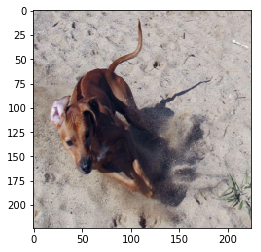

In [21]:
### Disply Image and the captions retrieved along with ground truth captions ##

imgid=12
img=new_image_tensor[imgid,:,:,:]
img = img.permute(1,2,0)
color_img = img.numpy()
color_img = (color_img - np.amin(color_img)) / np.ptp(color_img)
plt.imshow(color_img)

cur_ground_truth_captions=ground_truth_captions[imgid]
print ("**************************************************")
print ("The Ground Truth Captions are:")
k=1
for gtcaption in cur_ground_truth_captions:
    print (k,": ",gtcaption[0])
    k=k+1
print ("**************************************************")

cur_image_output=torch.unsqueeze(image_output[imgid,:,:,:],dim=0)
sim_mat = compute_matchmap_similarity_matrix(cur_image_output,caption_glove_tensor_output,score_type)
I2C_scores, I2C_ind = sim_mat.topk(5,1)
I2C_ind=I2C_ind.tolist()[0]

print ("**************************************************")
k=1
print ("The predicted captions are:")
for captid in I2C_ind: 
    print (k,": ",captions[captid][0])
    k=k+1
print ("**************************************************")


#image_output, caption_glove_tensor_output = get_output(image_tensor,image_model,new_caption,caption_model)
#sim_mat = get_sim_mat(image_output,caption_glove_tensor_output,score_type)
#sim_mat = torch.Tensor(sim_mat)
#C2I_scores, C2I_ind = sim_mat.topk(1,0)
#I2C_scores, I2C_ind = sim_mat.topk(5,0)

**********************************************
Caption of Interest is:
A brown dog is running in the sand .
**********************************************


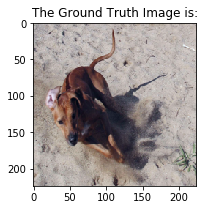

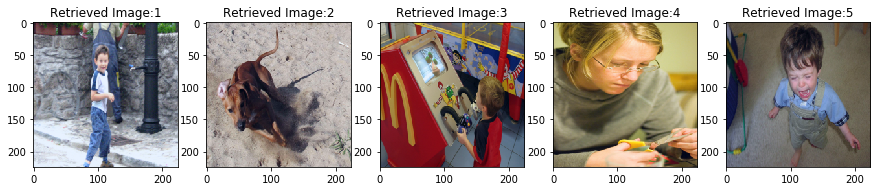

In [22]:
### Disply Caption and the Images retrieved along with ground truth captions ##

capid=55
cur_caption=captions[capid][0]

print ("**********************************************")
print ("Caption of Interest is:")
print (cur_caption)
print ("**********************************************")

gt_image_id=cap_img_corr[capid]

plt.figure(figsize=(3,3))
img=new_image_tensor[gt_image_id,:,:,:]
img = img.permute(1,2,0)
color_img = img.numpy()
color_img = (color_img - np.amin(color_img)) / np.ptp(color_img)
plt.imshow(color_img)
plt.title("The Ground Truth Image is:")

cur_caption_output=torch.unsqueeze(caption_glove_tensor_output[capid,:,:],dim=0)
sim_mat = compute_matchmap_similarity_matrix(image_output,cur_caption_output,score_type)
C2I_scores, C2I_ind = sim_mat.topk(5,0)

k=1
g = plt.figure(figsize=(15,15))
for i in range(len(C2I_ind)):
    subplotid="15"+str(i+1)
    cur_image_tensor=new_image_tensor[C2I_ind[i]]
    img = torch.squeeze(cur_image_tensor,0)
    img = img.permute(1,2,0)
    color_img = img.numpy()
    color_img = (color_img - np.amin(color_img)) / np.ptp(color_img)
    plt.subplot(int(subplotid))
    plt.imshow(color_img)
    plt.title("Retrieved Image:"+str(k))
    k=k+1
g.show()